### File Explanation

**trainRNN_HBTRC_StaticModel_learningRate.ipynb:**
<br> This notebook is to load HBTRC examples from 'preprocessData_HBTRC.pickle', create a "Static Network" and train the network with respect to a range of learning rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer static model (function: **LSTM_Model** in **trainRNN_network_utils.py**)
<br> 5) Create a single normalised output by using the last outputs of static models of gene A and gene B (function: **batch_normalised_sum** in **trainRNN_network_utils.py**)
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 7) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 8) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 9) Save them in "resultsStaticLearningRate_HBTRC.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData_HBTRC.ipynb"

# Save data into Python file
import pickle
with open('preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    sGeneNames_tr_nX2 = pickle.load( f )
    sGeneNames_tst_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data saved into pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [10]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropout = 0.6                                       # dropout percentage

## Training data
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_size = 100
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches

### Network and Train

In [11]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
for learning_rate in learning_rates:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])
        init_state_A = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

        hidden_output_A, current_state_A = LSTM_Model(rSnpRnaA_pXNS, 
                                                      init_state_A, 
                                                      n_layer, 
                                                      n_hidden, 
                                                      dropout)

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])
        init_state_B = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

        hidden_output_B, current_state_B = LSTM_Model(rSnpRnaB_pXNS, 
                                                      init_state_B, 
                                                      n_layer, 
                                                      n_hidden,
                                                      dropout)

    hidden_output = batch_normalised_sum(hidden_output_A, hidden_output_B)

    ## Output placeholder
    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')

    # Dense Layer
    logit = tf.layers.dense( hidden_output,
                            units = n_classes, 
                            activation = None,
                            kernel_initializer = tf.initializers.random_normal() ) 

    prediction = tf.nn.softmax( logit )

    ## Loss and optimiser
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                         labels=tf.argmax(rRelated_pXC,1)))

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            # Initial current_state
            _current_state_A = np.zeros((n_layer, 2, batch_size, n_hidden))
            _current_state_B = np.zeros((n_layer, 2, batch_size, n_hidden))
            _current_state_tst_A = np.zeros((n_layer, 2, rSnpA_tst_nXSN.shape[0], n_hidden))
            _current_state_tst_B = np.zeros((n_layer, 2, rSnpA_tst_nXSN.shape[0], n_hidden))

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC,
                        init_state_A: _current_state_A,                      
                        init_state_B: _current_state_B,                       
                    })

                tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC,
                        init_state_A: _current_state_tst_A,                      
                        init_state_B: _current_state_tst_B,
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
            
        trainLosses[learning_rate] = train_losses
        testLosses[learning_rate] = test_losses
        trainAccuracy[learning_rate] = train_accuracies
        F1_scores[learning_rate] = test_f1_score
        print("Optimisation finished!")



Data shuffled. Epoch:  0
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.009478673069247703

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.004587156031499929

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00302571851672559

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.0022573363005914324

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.001800180126879355

Data shuff

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00021195422455657205

Data shuffled. Epoch:  42
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00020701791751784467

Data shuffled. Epoch:  43
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00020230628372778624

Data shuffled. Epoch:  44
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00019780435915094224

Data shuffled. Epoch:  45
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.0001934984446695585

Data shuffled. Epoch: 

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00010717538547264111

Data shuffled. Epoch:  83
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00010589854821908065

Data shuffled. Epoch:  84
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00010465177390260702

Data shuffled. Epoch:  85
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00010343400584217855

Data shuffled. Epoch:  86
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00010224426188561258

Data shuffled. Epoch:

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 7.172057160624969e-05

Data shuffled. Epoch:  124
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 7.114653004031455e-05

Data shuffled. Epoch:  125
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 7.058159610441588e-05

Data shuffled. Epoch:  126
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 7.00255600834479e-05

Data shuffled. Epoch:  127
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 6.94782192705093e-05

Data shuffled. Epoch:  1

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 5.3892377386853984e-05

Data shuffled. Epoch:  165
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 5.356760105056664e-05

Data shuffled. Epoch:  166
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 5.324671987968288e-05

Data shuffled. Epoch:  167
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 5.292965566125208e-05

Data shuffled. Epoch:  168
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 5.261634566245032e-05

Data shuffled. Epoch:

Performance on training data: Loss = 1.1891592741012573: Accuracy = 0.33000001311302185
Performance on test set: : Loss = 1.1852149963378906: Accuracy = 0.5851677740061197

Data shuffled. Epoch:  6
Performance on training data: Loss = 1.2332640886306763: Accuracy = 0.28999999165534973
Performance on test set: : Loss = 1.1464232206344604: Accuracy = 0.611706750631279

Data shuffled. Epoch:  7
Performance on training data: Loss = 1.249639630317688: Accuracy = 0.25999999046325684
Performance on test set: : Loss = 1.144169569015503: Accuracy = 0.6353533808449067

Data shuffled. Epoch:  8
Performance on training data: Loss = 1.1540560722351074: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.1768474578857422: Accuracy = 0.6491837226940773

Data shuffled. Epoch:  9
Performance on training data: Loss = 1.126450777053833: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.116339087486267: Accuracy = 0.6466898615430802

Data shuffled. Epoch:  10
Performance on t

Performance on training data: Loss = 1.104030966758728: Accuracy = 0.3100000023841858
Performance on test set: : Loss = 1.0961636304855347: Accuracy = 0.692527323147098

Data shuffled. Epoch:  48
Performance on training data: Loss = 1.0930213928222656: Accuracy = 0.2199999988079071
Performance on test set: : Loss = 1.1001336574554443: Accuracy = 0.692080458432358

Data shuffled. Epoch:  49
Performance on training data: Loss = 1.0705389976501465: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.098851203918457: Accuracy = 0.6918721236276617

Data shuffled. Epoch:  50
Performance on training data: Loss = 1.1027086973190308: Accuracy = 0.33000001311302185
Performance on test set: : Loss = 1.1032401323318481: Accuracy = 0.6914598432472608

Data shuffled. Epoch:  51
Performance on training data: Loss = 1.103710412979126: Accuracy = 0.25
Performance on test set: : Loss = 1.0934947729110718: Accuracy = 0.6923189883404157

Data shuffled. Epoch:  52
Performance on training data

Performance on training data: Loss = 1.074629545211792: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.108640193939209: Accuracy = 0.7011321075682148

Data shuffled. Epoch:  90
Performance on training data: Loss = 1.060347557067871: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.1308624744415283: Accuracy = 0.7008966749700776

Data shuffled. Epoch:  91
Performance on training data: Loss = 1.0821914672851562: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.098962664604187: Accuracy = 0.7005302987821352

Data shuffled. Epoch:  92
Performance on training data: Loss = 1.0631818771362305: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.1040501594543457: Accuracy = 0.7000932413893486

Data shuffled. Epoch:  93
Performance on training data: Loss = 1.0916951894760132: Accuracy = 0.3199999928474426
Performance on test set: : Loss = 1.0954582691192627: Accuracy = 0.7001343730882482

Data shuffled. Epoch:  94
Performance

Performance on training data: Loss = 0.9266607165336609: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.2218573093414307: Accuracy = 0.6395023256233723

Data shuffled. Epoch:  132
Performance on training data: Loss = 0.9409825205802917: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.2505221366882324: Accuracy = 0.6369649498044923

Data shuffled. Epoch:  133
Performance on training data: Loss = 0.9254210591316223: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.2264609336853027: Accuracy = 0.6346347547341508

Data shuffled. Epoch:  134
Performance on training data: Loss = 0.9665192365646362: Accuracy = 0.5
Performance on test set: : Loss = 1.2849249839782715: Accuracy = 0.6322736284804619

Data shuffled. Epoch:  135
Performance on training data: Loss = 0.989017128944397: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.2544753551483154: Accuracy = 0.6298576377344164

Data shuffled. Epoch:  136
Performance on traini

Performance on training data: Loss = 0.904335618019104: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.1974010467529297: Accuracy = 0.5665229903700221

Data shuffled. Epoch:  174
Performance on training data: Loss = 0.9132788181304932: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.220954418182373: Accuracy = 0.5651311760681306

Data shuffled. Epoch:  175
Performance on training data: Loss = 0.9023314118385315: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1879494190216064: Accuracy = 0.5637456904391824

Data shuffled. Epoch:  176
Performance on training data: Loss = 0.8870227932929993: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.2068119049072266: Accuracy = 0.5622810913111002

Data shuffled. Epoch:  177
Performance on training data: Loss = 0.93697190284729: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.205473780632019: Accuracy = 0.5606864533244902

Data shuffled. Epoch:  178
Performanc

Performance on training data: Loss = 1.1115907430648804: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.1742912530899048: Accuracy = 0.5287277137261371

Data shuffled. Epoch:  16
Performance on training data: Loss = 1.093300461769104: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.0769991874694824: Accuracy = 0.5386653592361265

Data shuffled. Epoch:  17
Performance on training data: Loss = 1.0936371088027954: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.1365717649459839: Accuracy = 0.5397258007764443

Data shuffled. Epoch:  18
Performance on training data: Loss = 1.1014347076416016: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.0881198644638062: Accuracy = 0.5396074856222561

Data shuffled. Epoch:  19
Performance on training data: Loss = 1.0797840356826782: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.0909308195114136: Accuracy = 0.5462644353492166

Data shuffled. Epoch:  20
Performan

Performance on training data: Loss = 1.1503452062606812: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.2382749319076538: Accuracy = 0.711946197465986

Data shuffled. Epoch:  58
Performance on training data: Loss = 1.1758029460906982: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.1650489568710327: Accuracy = 0.7068758322586112

Data shuffled. Epoch:  59
Performance on training data: Loss = 1.1592602729797363: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.2071624994277954: Accuracy = 0.702039657215612

Data shuffled. Epoch:  60
Performance on training data: Loss = 1.080102562904358: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.1415562629699707: Accuracy = 0.699386452114439

Data shuffled. Epoch:  61
Performance on training data: Loss = 1.1355042457580566: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.2091681957244873: Accuracy = 0.6968293929868722

Data shuffled. Epoch:  62
Performance o

Performance on training data: Loss = 1.0873208045959473: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.1069363355636597: Accuracy = 0.6416409391533656

Data shuffled. Epoch:  100
Performance on training data: Loss = 1.067989706993103: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.0841810703277588: Accuracy = 0.6405202645446282

Data shuffled. Epoch:  101
Performance on training data: Loss = 1.0699260234832764: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.1171627044677734: Accuracy = 0.6398979889986824

Data shuffled. Epoch:  102
Performance on training data: Loss = 1.085332989692688: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.0980241298675537: Accuracy = 0.6387148047018546

Data shuffled. Epoch:  103
Performance on training data: Loss = 1.0408127307891846: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.1052414178848267: Accuracy = 0.6383305533423187

Data shuffled. Epoch:  104
Perfor

Performance on training data: Loss = 1.100091576576233: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.1032710075378418: Accuracy = 0.6410532269756655

Data shuffled. Epoch:  142
Performance on training data: Loss = 1.0967075824737549: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.0900352001190186: Accuracy = 0.6414264341244806

Data shuffled. Epoch:  143
Performance on training data: Loss = 1.1231935024261475: Accuracy = 0.33000001311302185
Performance on test set: : Loss = 1.1271908283233643: Accuracy = 0.641693401372828

Data shuffled. Epoch:  144
Performance on training data: Loss = 1.0774422883987427: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.1151165962219238: Accuracy = 0.6416829441431242

Data shuffled. Epoch:  145
Performance on training data: Loss = 1.101372241973877: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.1665945053100586: Accuracy = 0.6415959899142766

Data shuffled. Epoch:  146
Perfo

Performance on training data: Loss = 0.9419898986816406: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.1535980701446533: Accuracy = 0.6540790019630771

Data shuffled. Epoch:  184
Performance on training data: Loss = 0.9008911848068237: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1291261911392212: Accuracy = 0.6549622522877471

Data shuffled. Epoch:  185
Performance on training data: Loss = 0.8565943241119385: Accuracy = 0.6700000166893005
Performance on test set: : Loss = 1.1426533460617065: Accuracy = 0.6558497792156374

Data shuffled. Epoch:  186
Performance on training data: Loss = 0.9379972219467163: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.1114522218704224: Accuracy = 0.6567373467157518

Data shuffled. Epoch:  187
Performance on training data: Loss = 0.9114096164703369: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.0858385562896729: Accuracy = 0.6576484112926211

Data shuffled. Epoch:  188
Perfor

Performance on training data: Loss = 1.0778756141662598: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.091734766960144: Accuracy = 0.3801523566118687

Data shuffled. Epoch:  26
Performance on training data: Loss = 1.0972579717636108: Accuracy = 0.33000001311302185
Performance on test set: : Loss = 1.107039213180542: Accuracy = 0.3807316488213873

Data shuffled. Epoch:  27
Performance on training data: Loss = 1.0960067510604858: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.103636384010315: Accuracy = 0.37983233590144705

Data shuffled. Epoch:  28
Performance on training data: Loss = 1.023463487625122: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.1186968088150024: Accuracy = 0.3813721945938647

Data shuffled. Epoch:  29
Performance on training data: Loss = 1.0363311767578125: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.1067183017730713: Accuracy = 0.3835860701157298

Data shuffled. Epoch:  30
Performance

Performance on training data: Loss = 0.9381504058837891: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.219205617904663: Accuracy = 0.27574961688787014

Data shuffled. Epoch:  68
Performance on training data: Loss = 0.9865589141845703: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.1931817531585693: Accuracy = 0.2733577421344722

Data shuffled. Epoch:  69
Performance on training data: Loss = 0.9526891112327576: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.2314491271972656: Accuracy = 0.2711229702465448

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.922700822353363: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.2147749662399292: Accuracy = 0.268903312221904

Data shuffled. Epoch:  71
Performance on training data: Loss = 0.9631460309028625: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.2168301343917847: Accuracy = 0.26734728700587235

Data shuffled. Epoch:  72
Performance

Performance on training data: Loss = 0.9097248911857605: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.221613883972168: Accuracy = 0.19793614768289663

Data shuffled. Epoch:  110
Performance on training data: Loss = 0.922499418258667: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.217367172241211: Accuracy = 0.19639912501043225

Data shuffled. Epoch:  111
Performance on training data: Loss = 0.8699991703033447: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.2135926485061646: Accuracy = 0.1950396273737969

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.9188159108161926: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.2121037244796753: Accuracy = 0.19380697586587192

Data shuffled. Epoch:  113
Performance on training data: Loss = 0.9171842336654663: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.2081153392791748: Accuracy = 0.19319667607851984

Data shuffled. Epoch:  114
Perfor

Performance on training data: Loss = 0.8841119408607483: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.217886209487915: Accuracy = 0.16539594102422003

Data shuffled. Epoch:  152
Performance on training data: Loss = 0.9228765368461609: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.229241967201233: Accuracy = 0.16443609267712608

Data shuffled. Epoch:  153
Performance on training data: Loss = 0.9362305402755737: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.2173662185668945: Accuracy = 0.16394775039848347

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.9295724630355835: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1873120069503784: Accuracy = 0.1637812363583302

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.9255244731903076: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1927220821380615: Accuracy = 0.16334675600739654

Data shuffled. Epoch:  156
Per

Performance on training data: Loss = 0.8654494285583496: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.2348146438598633: Accuracy = 0.14354931239754767

Data shuffled. Epoch:  194
Performance on training data: Loss = 0.9065362811088562: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.2246266603469849: Accuracy = 0.1428790294354198

Data shuffled. Epoch:  195
Performance on training data: Loss = 0.881690502166748: Accuracy = 0.6899999976158142
Performance on test set: : Loss = 1.2203913927078247: Accuracy = 0.1422367772420442

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.8817675113677979: Accuracy = 0.6499999761581421
Performance on test set: : Loss = 1.2076290845870972: Accuracy = 0.14162356243814436

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.9139170050621033: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.215466856956482: Accuracy = 0.14097422822232372

Data shuffled. Epoch:  198
Perf

Performance on training data: Loss = 1.0939403772354126: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.0895999670028687: Accuracy = 0.0626770771509835

Data shuffled. Epoch:  36
Performance on training data: Loss = 1.0973591804504395: Accuracy = 0.3499999940395355
Performance on test set: : Loss = 1.1068066358566284: Accuracy = 0.06193693107812105

Data shuffled. Epoch:  37
Performance on training data: Loss = 1.109565019607544: Accuracy = 0.3100000023841858
Performance on test set: : Loss = 1.1091492176055908: Accuracy = 0.06089532816762932

Data shuffled. Epoch:  38
Performance on training data: Loss = 1.1026767492294312: Accuracy = 0.30000001192092896
Performance on test set: : Loss = 1.0921276807785034: Accuracy = 0.05981488207371613

Data shuffled. Epoch:  39
Performance on training data: Loss = 1.1037651300430298: Accuracy = 0.33000001311302185
Performance on test set: : Loss = 1.0983188152313232: Accuracy = 0.058884944872013144

Data shuffled. Epoch:  40
Perf

Performance on training data: Loss = 1.093850016593933: Accuracy = 0.33000001311302185
Performance on test set: : Loss = 1.098957896232605: Accuracy = 0.04793406301773297

Data shuffled. Epoch:  78
Performance on training data: Loss = 1.0955005884170532: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.0958226919174194: Accuracy = 0.04813406623659952

Data shuffled. Epoch:  79
Performance on training data: Loss = 1.0992661714553833: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.0919448137283325: Accuracy = 0.04812523356679844

Data shuffled. Epoch:  80
Performance on training data: Loss = 1.0897207260131836: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.093346357345581: Accuracy = 0.04816255993832373

Data shuffled. Epoch:  81
Performance on training data: Loss = 1.094085454940796: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.0909768342971802: Accuracy = 0.048149864416767094

Data shuffled. Epoch:  82
Perform

Performance on training data: Loss = 1.0860595703125: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.0923992395401: Accuracy = 0.13619881946810647

Data shuffled. Epoch:  120
Performance on training data: Loss = 1.099874496459961: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.0859906673431396: Accuracy = 0.1385346621960758

Data shuffled. Epoch:  121
Performance on training data: Loss = 1.0847245454788208: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.099313497543335: Accuracy = 0.1412299138763995

Data shuffled. Epoch:  122
Performance on training data: Loss = 1.0882271528244019: Accuracy = 0.41999998688697815
Performance on test set: : Loss = 1.0847023725509644: Accuracy = 0.14490473941343676

Data shuffled. Epoch:  123
Performance on training data: Loss = 1.0891789197921753: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.090763807296753: Accuracy = 0.148099921145091

Data shuffled. Epoch:  124
Performance

Performance on training data: Loss = 1.0250270366668701: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.138809323310852: Accuracy = 0.32644742736518995

Data shuffled. Epoch:  162
Performance on training data: Loss = 0.9788843393325806: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1207423210144043: Accuracy = 0.330721526115074

Data shuffled. Epoch:  163
Performance on training data: Loss = 0.9724997878074646: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.1619277000427246: Accuracy = 0.33501385817371165

Data shuffled. Epoch:  164
Performance on training data: Loss = 1.0284457206726074: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.1132464408874512: Accuracy = 0.3391950306404664

Data shuffled. Epoch:  165
Performance on training data: Loss = 1.035723090171814: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.1532318592071533: Accuracy = 0.34328164354458685

Data shuffled. Epoch:  166
Per

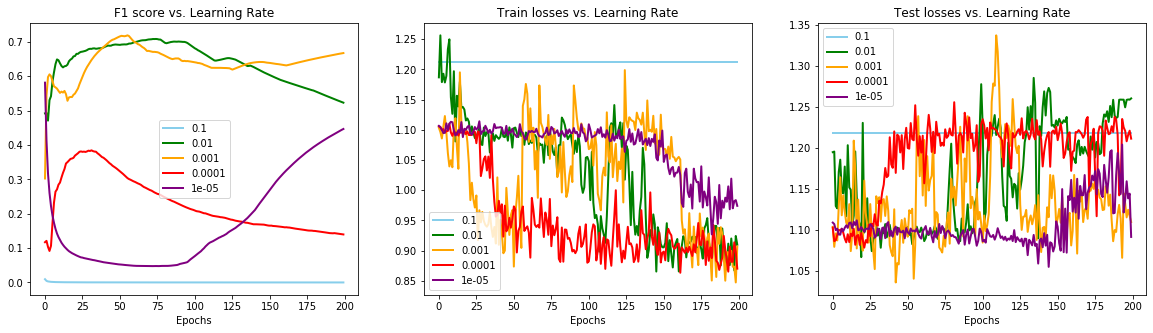

In [13]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Learning Rate")

In [14]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsStaticLearningRate_HBTRC.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
